In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import random
import keras

In [2]:
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box

In [3]:
data_cons = pd.read_csv("consumer_data_hourly.csv")
data_elec = pd.read_csv("electricity price data hourly.csv")

In [4]:
print(data_elec.columns)

Index(['datetime_beginning_utc', 'system_energy_price_da'], dtype='object')


In [5]:
print(data_cons.columns)

Index(['dateTime', 'use'], dtype='object')


In [6]:
data_elec.head(6)

,datetime_beginning_utc,system_energy_price_da
0,01-01-2022 05:00,21.02
1,01-01-2022 06:00,18.43
2,01-01-2022 07:00,18.11
3,01-01-2022 08:00,18.15
4,01-01-2022 09:00,17.70
5,01-01-2022 10:00,17.67


In [7]:
data_elec.rename(columns={'system_energy_price_da':'price'},inplace = True)

In [8]:
data_elec.head()

,datetime_beginning_utc,price
0,01-01-2022 05:00,21.02
1,01-01-2022 06:00,18.43
2,01-01-2022 07:00,18.11
3,01-01-2022 08:00,18.15
4,01-01-2022 09:00,17.70


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
data_elec['price'] = scaler.fit_transform(data_elec[['price']])

In [11]:
data_elec.head()

,datetime_beginning_utc,price
0,01-01-2022 05:00,0.016487
1,01-01-2022 06:00,0.010621
2,01-01-2022 07:00,0.009897
3,01-01-2022 08:00,0.009987
4,01-01-2022 09:00,0.008968


In [12]:
data_cons.rename(columns={'use':'usage'},inplace = True)

In [13]:
data_cons.head()

,dateTime,usage
0,2016-01-01 00:00:00,2.108533
1,2016-01-01 01:00:00,1.852600
2,2016-01-01 02:00:00,1.988000
3,2016-01-01 03:00:00,1.993267
4,2016-01-01 04:00:00,1.781533


In [14]:
print(data_cons.usage.max()," ",data_cons.usage.min())
print(data_elec.price.max()," ",data_elec.price.min())

29.8692   0.0
1.0   0.0


In [15]:
print(data_cons.usage.median(), " ", data_cons.usage.mean())

3.519333333333332   5.361010481177898


In [16]:
data_elec.shape

(8737, 2)

In [17]:
data_cons.shape

(8784, 2)

In [18]:
split_point = 7027
train_elec = data_elec[:split_point]
train_cons = data_cons[:split_point]
test_elec = data_elec[split_point:]
test_cons = data_cons[split_point:]
print(train_elec.shape, test_elec.shape)
print(train_cons.shape, test_cons.shape)

(7027, 2) (1710, 2)
(7027, 2) (1757, 2)


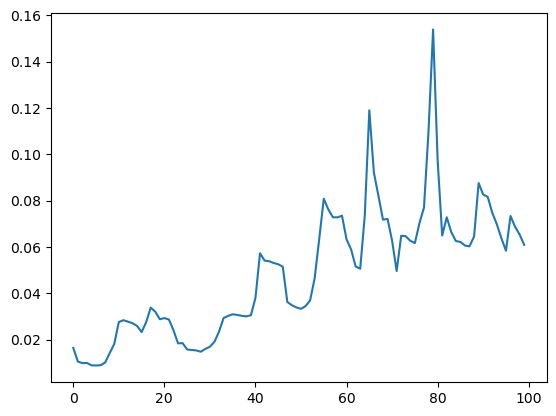

In [19]:
plt.plot(data_elec.price[:100])

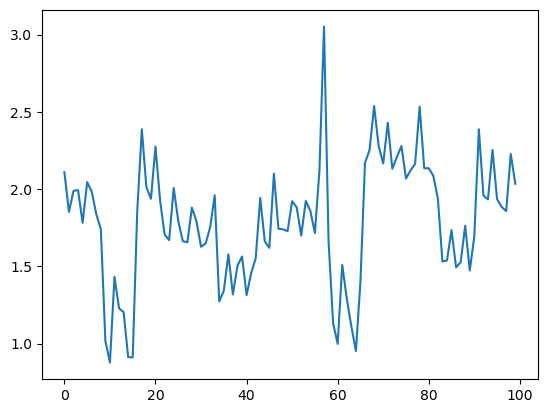

In [20]:
plt.plot(data_cons.usage[0:100])

In [21]:
data_usage = data_cons['usage'].values

In [22]:
data_price = data_elec['price'].values

In [23]:
data_price = data_elec['price'].values

# Print data_price to verify its contents
print(data_price)

[0.016487   0.01062143 0.00989673 ... 0.05358275 0.04538455 0.03641634]


In [24]:
print(data_price)

[0.016487   0.01062143 0.00989673 ... 0.05358275 0.04538455 0.03641634]


In [25]:
data_elec.head()

,datetime_beginning_utc,price
0,01-01-2022 05:00,0.016487
1,01-01-2022 06:00,0.010621
2,01-01-2022 07:00,0.009897
3,01-01-2022 08:00,0.009987
4,01-01-2022 09:00,0.008968


# Create Custom Environment of SmartGrid

In [26]:
class SmartGrid(Env):
    def __init__(self,data_usage,data_price):
        #load electricity price data
        
        self.data_price = data_price
        
        #load consumer price data
        self.data_usage = data_usage
        
        #set maximum battery capacity
        self.max_capacity = 10
        
        #Actions that we can take
        #0 == -3, 1 == -2, 2 == -1, 3 ==0 , 4 == 1, 5 == 2, 6== 3 total 7 actions to take 
        #-ve values stand for discharge and positive values stand for charge
        self.action_space = Discrete(7)
        
        # States: Household Consumption, Current Price, Battery Capacity
        self.observation_space = Box(low=np.array([0, 0, 0]), high=np.array([10, 1, 10]))
          
        #set initial start state
        self.state = np.array([0, 0, 0])
        
        #set initial position 
        self.time_step = 0
        
        #initiate profits
        self.profits =0
        
        #cost of buying
        
        
        #action history
        self.action_history = []
        
        #profits history
        self.profits_history = [] 
        
        #rewards history
        self.reward_history = []

        # Track overcharging start time
        self.overcharge_start_time = None
        
        # Track undercharging start time
        self.undercharge_start_time = None
        
        
    def step(self,action):
        reward = 0
    
        reward = self.custom_reward(action)
        reward += self.punishment_for_bad_choices( action)

        self.reward_history.append(reward)
        self.action_history.append(action - 3)  # Store the action in action_history
        self.profits_history.append(self.profits)

        if self.time_step > 1000:
            done = True
        else:
            done = False

        self.state += action - 3
        
        
        info = {}
        self.time_step += 1

        return self.state, reward, done, info
    
    def custom_reward(self,action):
        reward = 0

        # Calculate the change in profits due to the current action
        prev_profits = self.profits
        self.profits += (3 - action) * self.data_price[self.time_step]
        profit_change = self.profits - prev_profits

            # Define the reward based on the action type
        if action < 3:
            # Penalize buying (charging) actions by a factor (e.g., -1 times profit change)
            reward = -1 * profit_change  # Adjust the penalty factor as needed
        else:
            # Reward selling (discharging) actions based on profit change
            reward = 1 * profit_change  # Adjust the reward factor as needed

        return reward
        


    def punishment_for_bad_choices(self, action):
        punishment = 0
    
        # Define your criteria for bad choices and assign a punishment
        if action == 1 or action == 0 or action == 2:
            if self.state[2] < 0.1 * self.max_capacity:
                if self.undercharge_start_time is None:
                    # Start tracking undercharging
                    self.undercharge_start_time = self.time_step
                else:
                    # Calculate duration of undercharging
                    undercharge_duration = self.time_step - self.undercharge_start_time
                    # Penalize proportionally to undercharge duration
                    punishment = -4 * undercharge_duration
                
        elif action == 4 or action == 5 or action == 6:
            if self.state[2] > 0.9 * self.max_capacity:
                # Penalize if battery is overcharging
                if self.overcharge_start_time is None:
                    # Start tracking overcharging
                    self.overcharge_start_time = self.time_step
                else:
                    # Calculate duration of overcharging
                    overcharge_duration = self.time_step - self.overcharge_start_time
                    # Penalize proportionally to overcharge duration
                    punishment = -2 * overcharge_duration

        return punishment

        
    def render(self):
        #implement vizualization
        pass
    def reset(self):
        #reset the initial timestamp
        self.time_step =0
        self.profits = 0
        #empty the entire battery
        self.state = np.array([0, 0, 0])
        #set done state as false
        self.action_history = []
        self.profits_history = []
        self.reward_history = []

        self.overcharge_start_time = None
        self.undercharge_start_time = None
        
        return self.state
    def get_action_history(self):
        return self.action_history
    
    def get_time_step(self):
        return self.time_step
    def get_reward_history(self):
        return self.reward_history
    
    def get_profits_history(self):
        return self.profits_history
    

In [27]:
print(data_usage)

[ 2.10853333  1.8526      1.988      ... 10.92       13.1356
  9.11186667]


In [28]:
env = SmartGrid(data_usage,data_price)

/Users/kan3k1/miniforge3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [29]:
env.observation_space.sample()

array([0.44823816, 0.8151141 , 6.2966657 ], dtype=float32)

In [30]:
print(env.observation_space.shape)

(3,)


In [31]:
env = SmartGrid(data_usage, data_price)

In [32]:
import numpy as np
from gym.spaces import Discrete, Box

# Define the number of episodes
episodes = 10

# Run the episodes
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
        
    print('Episode:{} Score:{}'.format(episode, score))
    action_history = env.get_action_history()
    print(action_history)
    print(env.get_profits_history())
    print(env.get_reward_history())
    print(len(action_history), env.get_time_step())


Episode:1 Score:-565182.4992526494
[3, 0, 3, 2, 1, -2, 2, -3, -2, 3, 1, -1, -2, -2, 2, -1, 2, -3, 0, 1, -3, 1, -3, -2, 0, 3, 1, -3, 0, 1, -1, 3, -2, 2, 1, -1, -1, 2, -2, 3, -2, -2, -2, -1, 0, 3, -1, 1, 0, -3, 3, -1, -3, -2, -2, -2, -2, -2, 0, -1, 2, 1, 1, 0, 1, -3, -1, 0, 0, -3, -3, 3, 0, -3, 1, 1, 2, 1, 2, -3, 1, 0, -2, -3, -3, 1, -1, 1, 3, 1, 2, -1, -2, -2, -2, 2, -3, 3, -1, 2, 1, -2, 2, -2, 0, -3, 3, 2, 0, 0, -1, -1, 1, -2, 1, -2, 2, 2, -2, 2, -3, -2, 0, -3, 3, 3, -2, 1, 0, -3, -1, -2, 2, -1, -2, -2, -1, 0, -3, 3, 0, -2, -1, 1, 2, 1, 0, -2, -3, 0, -3, -1, 2, -1, 1, -1, -1, -3, 3, 2, 1, 1, 2, 3, 1, 0, 2, 1, 0, -2, 3, 0, -2, 1, 3, -1, 2, -3, 0, -2, 1, 1, -2, -1, -1, 0, -2, 3, 2, 3, -2, 3, 2, 2, -2, 1, -2, -1, 0, -1, -3, 2, 3, 2, 1, 0, 2, 3, 0, -3, -2, -3, 1, 2, -2, 3, 3, 3, -2, 3, 0, 2, -1, 2, 3, 0, 2, 1, 2, 1, 0, 2, 3, 1, -3, 3, 1, 1, -1, -3, -1, -2, 1, 1, -1, 3, 3, -3, -1, 3, 3, 1, -2, -2, -2, -3, -2, -1, 2, 1, -2, -3, -3, -3, 1, -2, 2, 2, 0, -2, -3, 2, 3, 0, -2, -3, 3, 3, -3, -3, 3

# Creating Deep Learning Model with Keras

In [61]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

/Users/kan3k1/miniforge3/lib/python3.10/site-packages


In [65]:
!pip install generic_utils

In [63]:
from tensorflow.python.keras.engine import keras_tensor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.utils import generic_utils
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


ImportError: cannot import name 'Progbar' from 'tensorflow.python.keras.utils' (/Users/kan3k1/miniforge3/lib/python3.10/site-packages/tensorflow/python/keras/utils/__init__.py)

In [53]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [54]:
states = env.observation_space.shape
actions = env.action_space.n

In [55]:
print(states)
print(actions)

(3,)
7


In [56]:
def build_model(states, actions):
    model = Sequential()
    
    model.add(Dense(24, activation='relu', input_shape=(1,)))  # Use input_shape as a tuple with a single integer
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [57]:
model = build_model(states, actions)

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                48        
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 7)                 175       
                                                                 
Total params: 823 (3.21 KB)
Trainable params: 823 (3.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
!pip install keras-utils

In [60]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

ModuleNotFoundError: No module named 'keras.utils.generic_utils'

In [45]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.3)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-4,gamma = 0.99)
    return dqn

In [46]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=30000, visualize=False, verbose=1)

NameError: name 'EpsGreedyQPolicy' is not defined

In [48]:
print(env.get_action_history())

[0, 0, 0, 0, 0, 1, 0, 1, 0, -2, 0, 2, 0, 3, 0, 0, 3, -1, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, -2, 0, 0, 3, -2, 3, 3, -2, 0, 0, 0, 0, 0, 0, 0, 0, -3, 3, 0, 0, -3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, -3, -2, -2, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 3, -1, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, 0, 0, 0, -2, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, -2, -2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, -2, 0, -3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 2, 1, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1, -1, -1, -1, 1, 2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, -3, 0, 0, -3, 1, 0, 0, 0, 0, 0, -1, -1, 0, 2, 0, 0, -1, -3, 2, 0, -1, 3, 0, -2, 0, 0, 0, 0, 0, -3, 3, 0, 0, 0, 0, 0, 0, 0, 

In [49]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 0.000, steps: 1002
Episode 2: reward: 0.000, steps: 1002
Episode 3: reward: 0.000, steps: 1002
Episode 4: reward: 0.000, steps: 1002
Episode 5: reward: 0.000, steps: 1002
Episode 6: reward: 0.000, steps: 1002
Episode 7: reward: 0.000, steps: 1002
Episode 8: reward: 0.000, steps: 1002
Episode 9: reward: 0.000, steps: 1002
Episode 10: reward: 0.000, steps: 1002
0.0


In [50]:
print(env.get_profits_history())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [51]:
print(env.get_reward_history())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,